# Zadatak 1

In [23]:
from skimage import color
import skimage
from skimage import io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pylab import *
import numpy as np
from scipy.signal import find_peaks
from scipy import ndimage

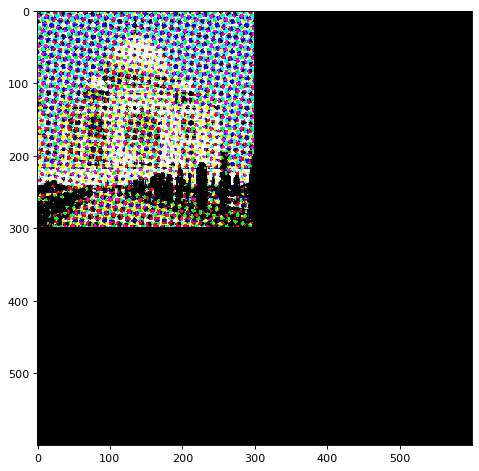

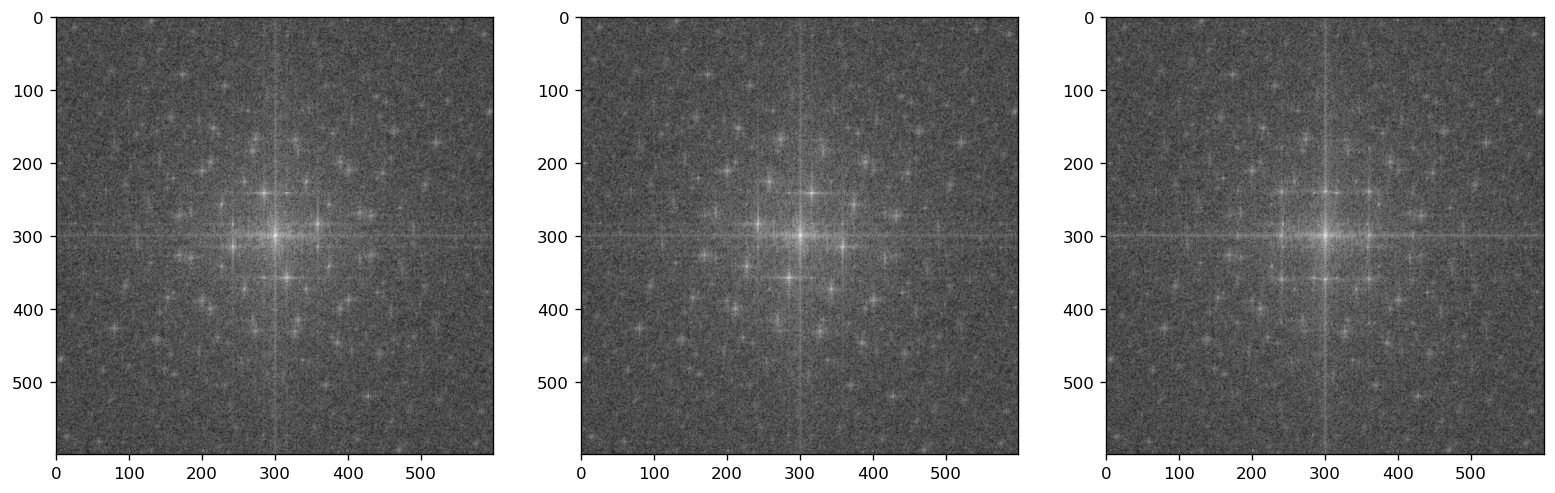

In [31]:
img = skimage.img_as_float(imread('../sekvence/half_tone.jpg'))
img_in = np.zeros([img.shape[0]*2, img.shape[1]*2,3], dtype = float)
img_in[:img.shape[0], :img.shape[1]] = img
plt.figure(num=None, figsize=(8, 6), dpi=80)
io.imshow(img_in)

img_out_fft = np.zeros(img_in.shape, dtype = complex)
img_out = np.zeros(img_in.shape)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,8), dpi=120)
ax = axes.ravel()

img_fft = np.zeros(img_in.shape, dtype=complex)
for i in range(3):
    img_fft[:, :, i] = np.fft.fftshift(np.fft.fft2(img_in[:, :, i]))
    img_amp = abs(img_fft[:, :, i])
    ax[i].imshow(log(1+img_amp), cmap='gray');

Sliku sam proširio nulama tako da joj dimenzije budu 2 puta veće zbog cirkularnosti konvolucije. Ovo su spektri za svaku komponentu R, G i B. kao što vidimo imamo više šumova. Prvo što sam učio to su ove vertikalne i horizontalne linije koje sam odlučio da sklonim.

In [29]:
def line_filtar(P: int, Q: int) -> np.array:
    filtar = np.ones([P, Q], dtype=float)
    filtar[math.floor(P/2)-1: math.floor(P/2)+2, :] = 0
    filtar[:, math.floor(Q/2)-1: math.floor(Q/2)+2] = 0
    filtar[math.floor(P/2)-10: math.floor(P/2)+11, math.floor(Q/2)-10: math.floor(Q/2)+11] = 1
    return filtar

Ovo je linijski filtar da sklonim te linijske elemente. Nakon tog filtriranja spektar izgleda ovako:

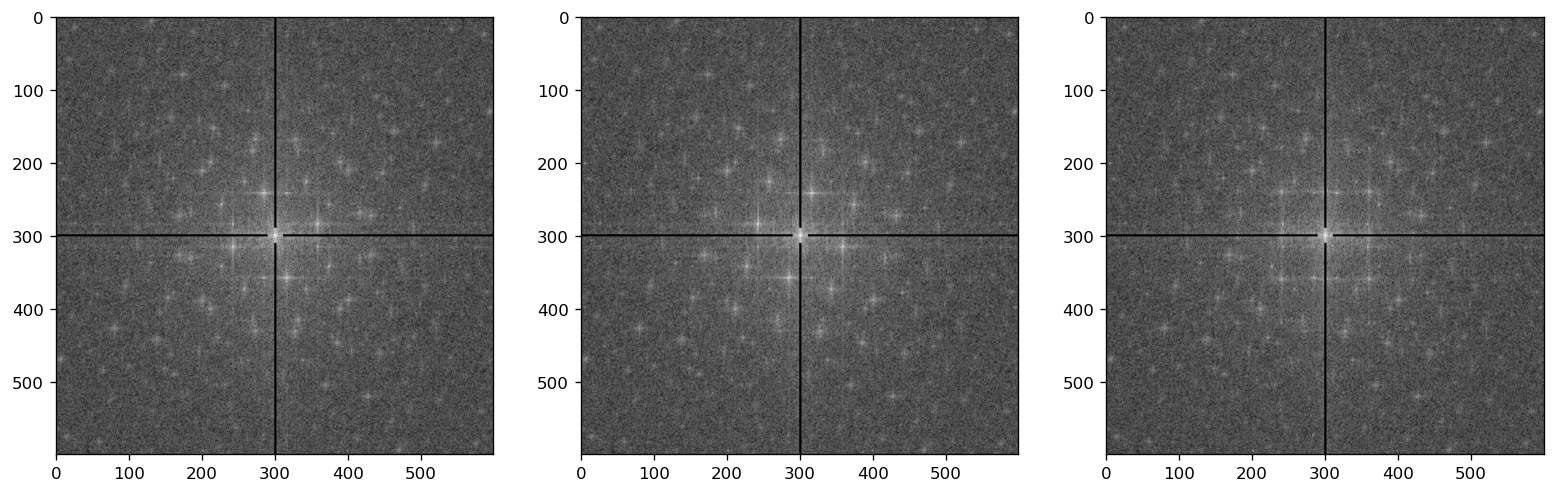

In [32]:
line = line_filtar(img_in.shape[0], img_in.shape[1])
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,8), dpi=120)
ax = axes.ravel()
for i in range(3):
    img_fft[:, :, i] = img_fft[:, :, i]*line
    img_amp = abs(img_fft[:, :, i])
    ax[i].imshow(log(1+img_amp), cmap='gray');

Ovo nije dovoljno jer ima mnogo pikova koji takođe predstavljaju šum. Zbog toga sam se odlučio da ubacim i propusnik niskih učestanosti, pošto ima pikova i na nžim i na višim učestanostima.

In [33]:
def gauss_filtar(P: int, Q: int) -> np.array:
    gauss = np.zeros([P, Q])
    sigma = 2000
    for u in range(P):
        for v in range(Q):
            D = (u - P/2)**2 + (v - Q/2)**2
            gauss[u, v] = exp(-D/sigma)
    return gauss

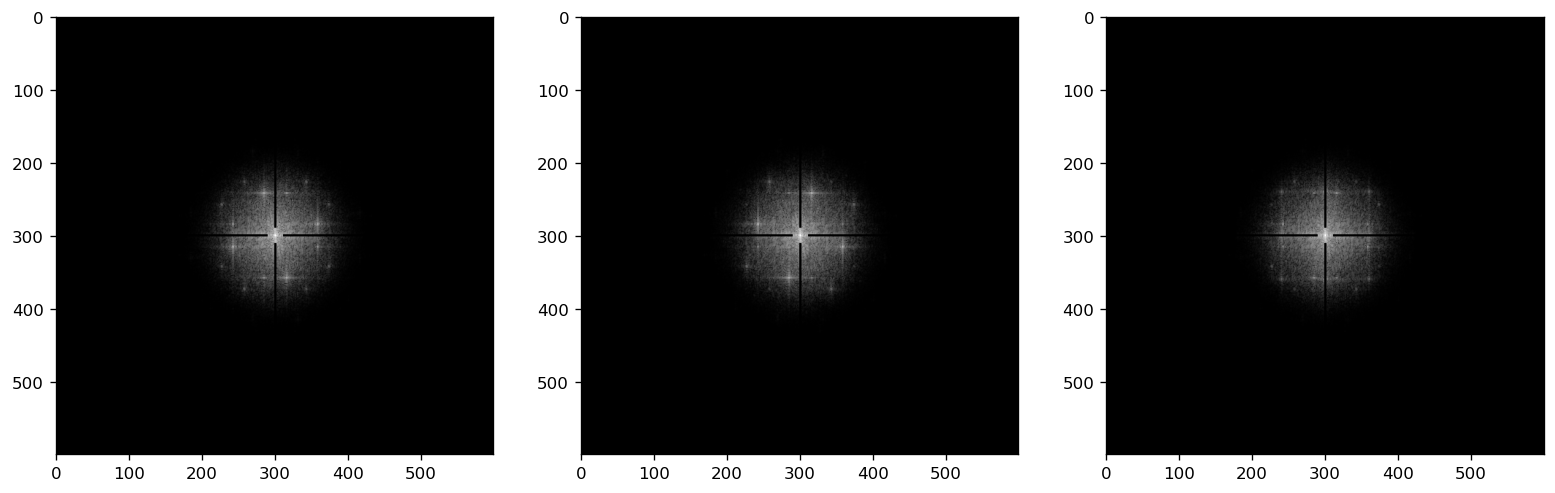

In [35]:
gauss = gauss_filtar(img_in.shape[0], img_in.shape[1])
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,8), dpi=120)
ax = axes.ravel()
for i in range(3):
    img_fft[:, :, i] = img_fft[:, :, i]*gauss
    img_amp = abs(img_fft[:, :, i])
    ax[i].imshow(log(1+img_amp), cmap='gray');

# Zadatak 2



In [1]:
import skimage
from pylab import *
import numpy as np
from skimage import io
import math

import matplotlib.pyplot as plt

Kako bismo uspeli da obnovimo sliku, moramo kernel da povećamo na veličinu slike. Kernel sam proširio nulama, jer tako ne remetim spekar slike. Sliku sam normalizovao da suma bude jednaka jedan, da bih za DC vrednost dobio jedan tako da kada budem filtrirao spekar ulazne slike ne promenim njenu DC vrednost. U DC vrednosti se nalazi informacija za boju i osvetljaj, i zbog toga ne želim da promenim vrednost DC komponente ulazne slike. Ulaznu sliku nisam proširivao nulama jer već u uglovima postoje 0, tako da filtriranje neće praviti problem. Na slici pokazujem ulaznu sliku i prošireni kernel.

Text(0.5, 1.0, 'Prosireni kernel')

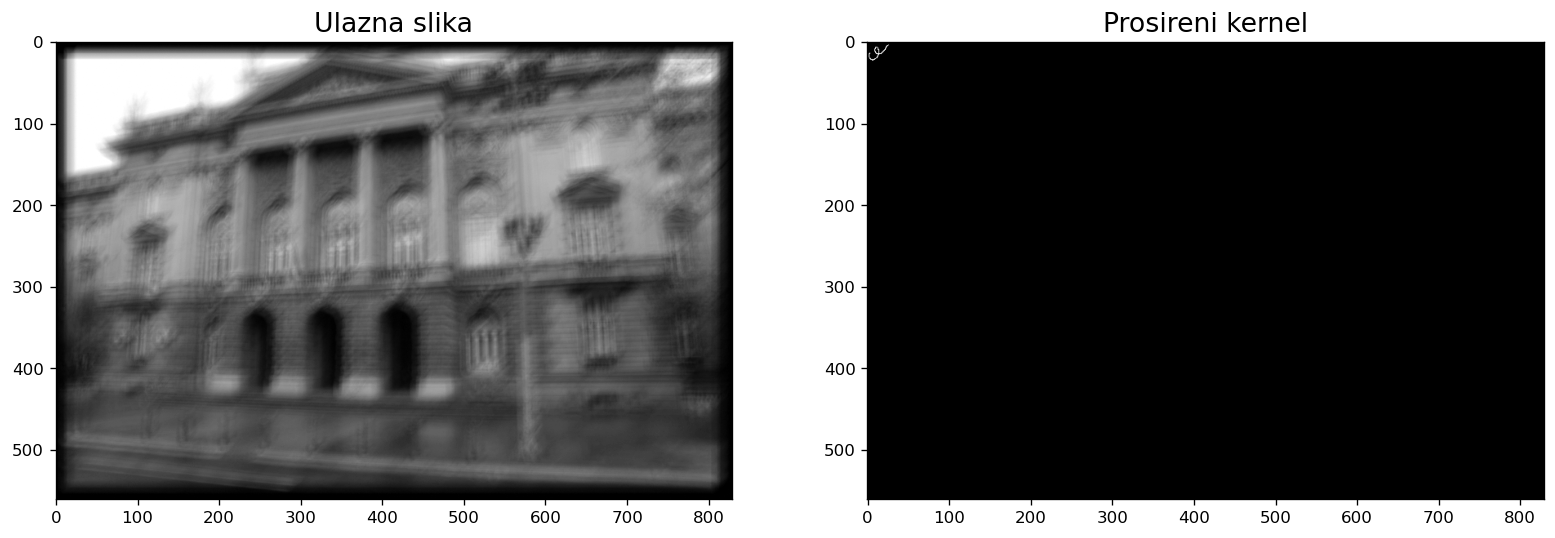

In [2]:
img_in = skimage.img_as_float(io.imread('../sekvence/etf_blur.tif'))
kernel = np.zeros(img_in.shape, dtype = float)
kernel1 = skimage.img_as_float(io.imread('../sekvence/kernel.tif'))
kernel1 = kernel1/np.sum(kernel1)
kernel[:kernel1.shape[0], :kernel1.shape[1]] = kernel1

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8), dpi=120)
ax = axes.ravel()

ax[0].imshow(img_in, cmap='gray'); ax[0].set_title('Ulazna slika', fontsize=16)
ax[1].imshow(kernel, cmap='gray'); ax[1].set_title('Prosireni kernel', fontsize=16)

Sada je potrebno odrediti spekar ulazne slike i kernela. Radi lakše analize spektra moramo da gledamo šiftovani spektar, jer običan fft određuje od 0 do fs spekar, a nam treba od -fs/2 do fs/2.

Text(0.5, 1.0, 'Spektar kernela')

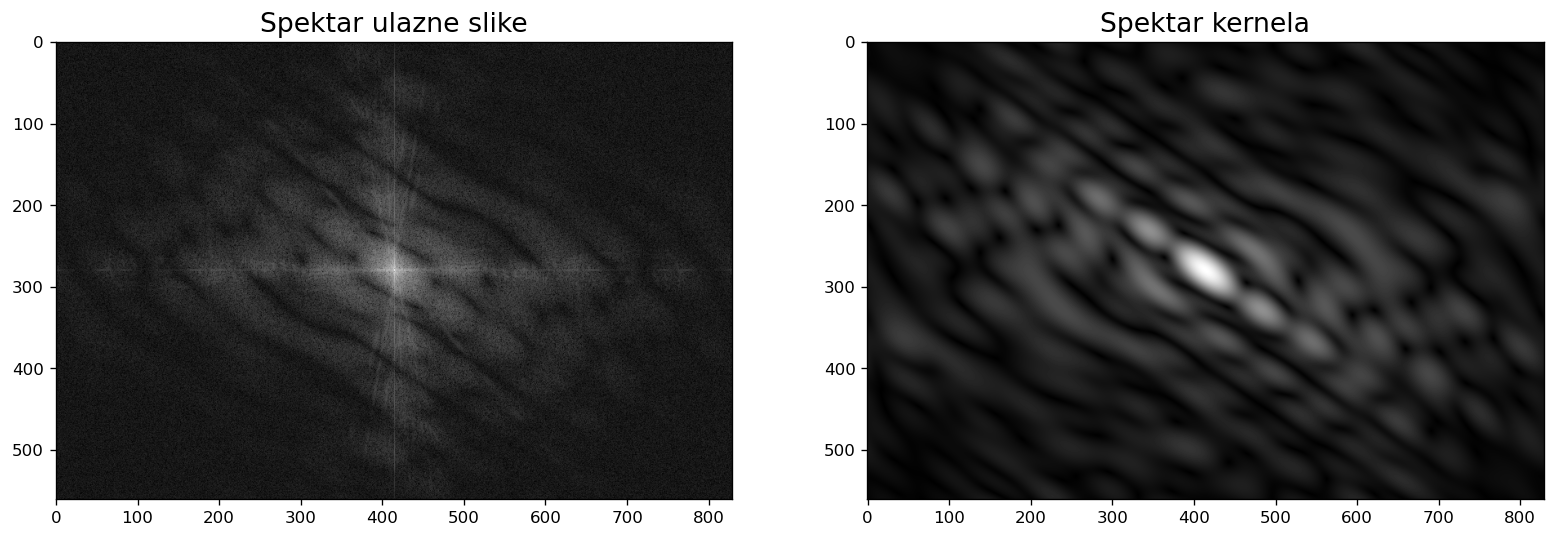

In [3]:
# FFT slike i kernela
img_fft = np.fft.fftshift(np.fft.fft2(img_in))
kernel_fft = np.fft.fftshift(np.fft.fft2(kernel))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8), dpi=120)
ax = axes.ravel()

ax[0].imshow(log(1+abs(img_fft)), cmap='gray'); ax[0].set_title('Spektar ulazne slike', fontsize=16)
ax[1].imshow(log(1+abs(kernel_fft)), cmap='gray'); ax[1].set_title('Spektar kernela', fontsize=16)

Za obradu slike nije moguće odraditi samo deljenje ova dva spektra jer je spektar kernela u nekim tačkama izuzetno mali pa neke vrednosti rezultata tog deljenja mogu da teže beskonačnosti. Zbog toga koristim Winer-ov filter.

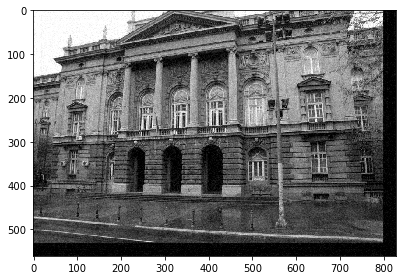

In [4]:
#Vinerov filtar
K = 0.001
F_est_fft = img_fft/kernel_fft*(abs(kernel_fft)**2/(abs(kernel_fft)**2+K))
f_est = np.fft.ifft2(np.fft.ifftshift(F_est_fft))

f_est[f_est<0] = 0
f_est[f_est>1] = 1

plt.figure()
io.imshow(real(f_est), cmap= 'gray')
    

Ovo je rezultat winer-ovog filtra. Kao što vidimo zadržali smo osvetljenost, što nam je bio cilj i slika sada ne izgleda pomereno, što nam je i bio cilj.
Ono što bih želeo da napomenem je da ukoliko u sliku nije ubačen dodatni šum, tada bismo mogli samo deljenjem spektra ulazne slike i spektra kernela da dobijemo dobar rezultat. Nisam siguran da li je u sliku ubačen šum, ali to možemo lako da proverimo tako što umesto za K=0.001 stavimo K=0.


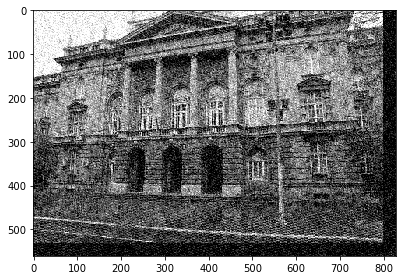

In [5]:
#Vinerov filtar
K=0
F_est_fft = img_fft/kernel_fft*(abs(kernel_fft)**2/(abs(kernel_fft)**2+K))
f_est = np.fft.ifft2(np.fft.ifftshift(F_est_fft))

f_est[f_est<0] = 0
f_est[f_est>1] = 1

plt.figure()
io.imshow(real(f_est), cmap= 'gray')

Kao što vidimo slika je imala šum, zbog toga je neophodno dodati K=0.001.

# Zadatak 3

In [ ]:
import skimage
from skimage import io
from skimage import color
import matplotlib.pyplot as plt
from scipy import ndimage

from pylab import *
import numpy as np


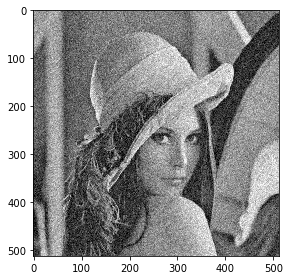

In [7]:
img_in = skimage.img_as_float(io.imread('..\sekvence\lena_noise.tif'))
io.imshow(img_in)

Ovo je ulazna slika, koja ima određenu količinu Gauss-ovog šuma. U nastavku se nalazi funkcija koja vraća varijansu šuma i okoline. sigma_n promenljiva je float tipa, dok je sigma_xz cela matrica.

In [8]:
def noise_surr_var(img_in: np.array, r: int) -> []:
    box = np.ones([2*r+1, 2*r+1], dtype=float)/(2*r+1)**2
    
    box_filtar = ndimage.correlate(img_in, box)
    square_box_filtar = ndimage.correlate(img_in**2, box)
    
    sigma_xy = square_box_filtar - box_filtar**2
    
    histogram, bins = np.histogram(sigma_xy.flatten(), bins=256)
    arg = np.argmax(histogram)
    
    sigma_n = bins[arg]
    return [sigma_n, sigma_xy]

Proverićemo kada šta se dešava sa varijansom šuma u zavisnosti od r.

In [14]:
r = np.arange(20)+1
print(r)
sigma_n_out = np.zeros(20, dtype=float)
for i in range(20):
    sigma_n_out[i], _ = noise_surr_var(img_in, r[i])
print(sigma_n_out)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[0.00486034 0.00633345 0.00690203 0.00700831 0.00703784 0.00709291
 0.00723613 0.00722919 0.0072262  0.0074688  0.00750956 0.00715144
 0.00733142 0.0073462  0.0073449  0.00745078 0.00716146 0.00722262
 0.00736121 0.0073829 ]


Iz rezultata vidimo da je r=1 i r=2 suviše malo, ali već za r=3 varijansa šuma kreće da konvergira. Nije dobro uzeti preveliko r jer nam je tada prozor prevelikih dimenzija i možemo da narušimo ivice. Zbog toga treba uzeti manje r, ali ne suviše malo jer može da se dobije premala varijansa šuma koja dalje utiče na to da se oslanjamo više na usrednjavanje malih blokova, što ne utiče dobro na šum. Zbog toga moj predlog je r=5.

Text(0.5, 1.0, 'Izlazna slika')

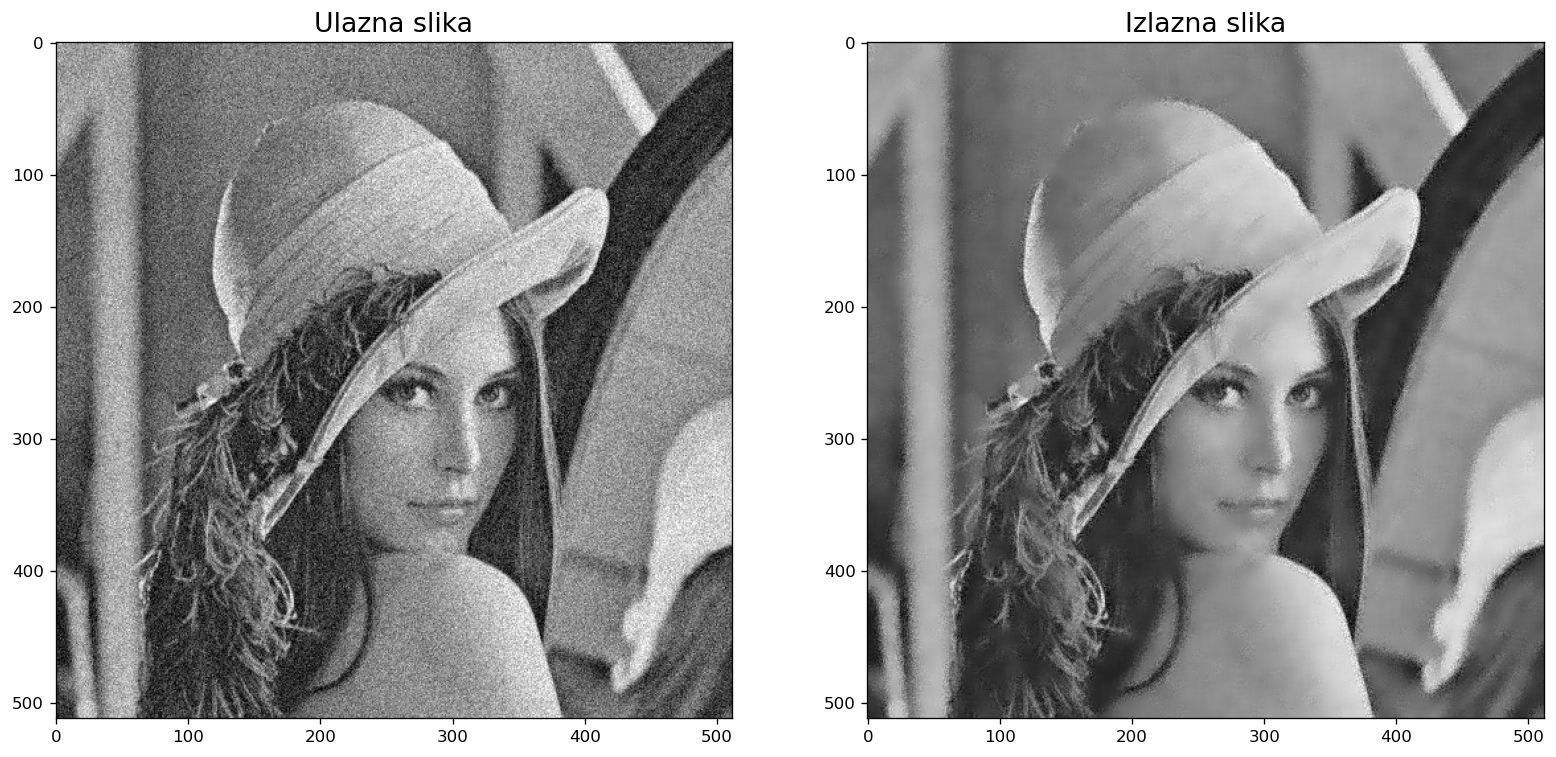

In [16]:
r = 5
sigma_n, sigma_xy = noise_surr_var(img_in, r)
w = sigma_n / sigma_xy
w[w>1] = 1

box = np.ones([2*r+1, 2*r+1], dtype=float)/(2*r+1)**2
box_filtar = ndimage.correlate(img_in, box)

img_out = img_in - w * (img_in - box_filtar)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8), dpi=120)
ax = axes.ravel()

ax[0].imshow(img_in, cmap='gray'); ax[0].set_title('Ulazna slika', fontsize=16)
ax[1].imshow(img_out, cmap='gray'); ax[1].set_title('Izlazna slika', fontsize=16)

# Zadatak 4
U ovom zadatku potrebno je da napravimo median filtar i adaptivni median filtar. Ta dva filtra su slična i oba daju dobre rezultate kod impulsnog šuma. Impulsni šum može da bude nezgodan ukoliko ne koristimo median filtar, jer on određene piksele stavlja na maksimalnu ili minimalnu vrednost, pa šum mnogo utiče na rezultate bilo kakvog usrednjavanja.

In [17]:
import matplotlib.pyplot as plt
from pylab import *

import random

import numpy as np
import math
from skimage import io
from skimage import color
from skimage import util

In [18]:
def find_max(matrix: np.array) -> int or float:
    output = matrix[0, 0]
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i, j]>output:
                output = matrix[i, j]
    return output

def find_min(matrix: np.array) -> int or float:
    output = matrix[0, 0]
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i, j]<output:
                output = matrix[i, j]
    return output

Ovo su funkcije koje određuju minimum i maksimum u matrici. Koristiću ove funkcije kod adaptivnog median filtra, koji ću objasniti kasnije.

In [19]:

def partition(arr, low, high) -> int:
    i = (low-1)
    pivot = arr[high]
 
    for j in range(low, high):
        if arr[j] <= pivot:
            i = i+1
            arr[i], arr[j] = arr[j], arr[i]
 
    arr[i+1], arr[high] = arr[high], arr[i+1]
    return (i+1)
 
def quick_sort(arr: np.array, low: int, high: int, middle: int) -> int or float:
    if len(arr) == 1:
        return arr
    if low < high:
        pi = partition(arr, low, high)
        if pi == middle:
            return arr[middle]
        # recursively sort two arrays with smaller and bigger members then pivot
        quick_sort(arr, low, pi-1, middle)
        quick_sort(arr, pi+1, high, middle)
    return arr[middle]

def find_median(matrix: np.array, window: int) -> int or float:
    arr = matrix.flatten()
    middle = math.floor(window*window/2)
    return quick_sort(arr, 0, arr.size-1, middle)

Ove tri funkcije sam koristio za određivanje medijane u matrici. Odlučio sam se za quick sort, jer je njegova složenost $n\cdot log(n)$. Ova dva algoritma su izuzetno složena zbog toga je bitno ubrzati algoritam što je više moguće.
Quick sort funkcioniše tako što uzme određenu član niza kao pivota (u ovom slučaju poslednji član niza) i podeli niz na manje od njega i na veće od njega. Tada smesti pivota na mesto gde pripada, pa nastavlja sortiranje ta dva podniza. Koristio sam baš ovaj metod jer može da se desi da ranije naiđem na medianu, pa u tom slučaju ne moram da sortiram ceo niz. U najgorem slučaju je složenost $n^2$ ukoliko za pivota uvek izaberemo najmanju ili najveću vrednost.

In [20]:
def make_mat(img_in: np.array, s_max: int, i: int, j: int) -> np.array:
    window = math.floor(s_max/2)
    
    # if it's inside the matrix
    if i+window+1 <= img_in.shape[0] and j+window+1 <= img_in.shape[1] and i-window>=0 and j-window>=0:
        return img_in[i-window:i+window+1, j-window:j+window+1]
    
    # if y axe goes outside of the image
    if i+window+1 > img_in.shape[0] and j+window+1 <= img_in.shape[1] and j-window>=0:
        mat = img_in[i-window:, j-window:j+window+1]
        con = img_in[2*img_in.shape[0]-i-window-1:, j-window:j+window+1]
        return np.concatenate((mat, con), axis=0)
    
    # if x axe goes outside of the image
    if i-window >= 0 and i+window+1 <= img_in.shape[0] and j+window+1 > img_in.shape[1]:
        mat = img_in[i-window:i+window+1, j-window:]
        con = img_in[i-window:i+window+1, 2*img_in.shape[1]-j-window-1:]
        return np.concatenate((mat, con), axis=1)
    
    # if x and y axes go outside of the image
    if i+window+1>img_in.shape[0] and j+window+1>img_in.shape[1]:
        mat = img_in[i-window:, j-window:]
        con1 = img_in[i-window:, 2*img_in.shape[1]-j-window-1:]
        mat = np.concatenate((mat, con1), axis=1)
        con2 = mat[img_in.shape[0]-i-window-1:, :]
        return np.concatenate((mat, con2), axis=0)
    
    # if y axe is smaller then 0
    if i-window<0 and j-window>=0 and j+window+1<=img_in.shape[1]:
        mat = img_in[:i+window+1, j-window:j+window+1]
        con = img_in[:window-i, j-window:j+window+1]
        return np.concatenate((mat, con), axis=0)
    
    # if x axe is smaller then 0
    if i-window>=0 and j-window<0 and i+window<=img_in.shape[0]:
        mat = img_in[i-window:i+window+1, :j+window+1]
        con = img_in[i-window:i+window+1, :window-j]
        return np.concatenate((mat, con), axis=1)
    
    # if y axe is smaller then 0 and x axe goes outside of the image
    if i-window<0 and j+window+1>img_in.shape[1]:
        mat = img_in[:i+window+1, j-window:]
        con1 = img_in[:i+window+1, 2*img_in.shape[1]-j-window-1:]
        mat = np.concatenate((mat, con1), axis=1)
        con2 = mat[:window-i, :]
        return np.concatenate((mat, con2), axis=0)
    
    # if x axe is smaller then 0 and y axe goes outside of the image
    if j-window<0 and i+window+1>img_in.shape[0]:
        mat = img_in[i-window:, :j+window+1]
        con1 = img_in[i-window:, :window-j]
        mat = np.concatenate((mat, con1), axis=1)
        con2 = mat[img_in.shape[0]-i-window-1:, :]
        return np.concatenate((mat, con2), axis=0)
    
    # if both axes goes outside of the image
    mat = img_in[:i+window+1, :j+window+1]
    con1 = img_in[:i+window+1, :window-j]
    mat = np.concatenate((mat, con1), axis=1)
    con2 = mat[:window-i, :]
    return np.concatenate((mat, con2), axis=0)

Ovo je funkcija koja za dati piksel određuje njegovu okolinu. Ima mnogo slučajeva kada maska izlazi iz okvira slike, pa je potrebno proširiti sliku sa svih strana.

In [21]:
def dos_median(img_in: np.array, s_max: int, adaptive: bool = False) ->np.array:
    """
    

    Parameters
    ----------
    img_in : np.array
        An input image.
    s_max : int
        Maximum window size.
    adaptive : bool
        True -> adaptive algorithm.

    Returns
    -------
    img_out : np.array
        A filtrated image.

    """
    img_out = np.zeros(img_in.shape)
    if not adaptive:
        window = s_max
        for i in range(img_in.shape[0]):
            for j in range(img_in.shape[1]):
                # for each pixel make the window
                matrix = make_mat(img_in, window, i, j)
                # filter the window
                img_out[i, j] = find_median(matrix, window)
    else:
        for i in range(img_in.shape[0]):
            for j in range(img_in.shape[1]):
                window = 3
                # if the window is smaller than maximum size of the window, and additional cases inside the while
                while window<=s_max:
                    # for each pixel make a window
                    matrix = make_mat(img_in, window, i, j)
                    if not img_in[i, j] == find_max(matrix) and not img_in[i, j] == find_min(matrix):
                        img_out[i, j]=img_in[i, j]
                        break
                    # find the median of the window
                    pom = find_median(matrix, window)
                    # if the median is different from maximum and minimum in the window -> this is the solution
                    if not window == s_max and (pom == find_max(matrix) or pom == find_min(matrix)):
                        window=window+2
                        continue
                    img_out[i, j] = pom
                    break
    return img_out

I konačno evo funkcije koja vraća median. Običan median filtar uzima median iz određene okoline (koja je konstantna) piksela i stavlja tu vrednost umesto tog piksela.
Pošto je bolje odrediti median iz što manje okoline, jer su manje okoline uniformnije, adaptivno median filtriranje kreće od najmanje veličine okoline (3x3). Ukoliko se desi da je broj minimalnih ili maksimalnih vrednosti veći od pola tada je median jednak tim vrednostima, pa nam rešenje nije dobro. Ukoliko dođe do toga tada povećavamo prozor. To ponavljamo sve dok nam se vrednost mediane ne promeni od maksimalne i minimalne vrednosti unutar prozora. Ukoliko nam je početna vrednost piksela različita od minimalne i maksimalne vrednosti unutar okoline, tada smatramo da nam taj piksel nije zašumljen i u izlaznu sliku stavljamo vrednost tog piksela.

Text(0.5, 1.0, 'Ulazna slika')

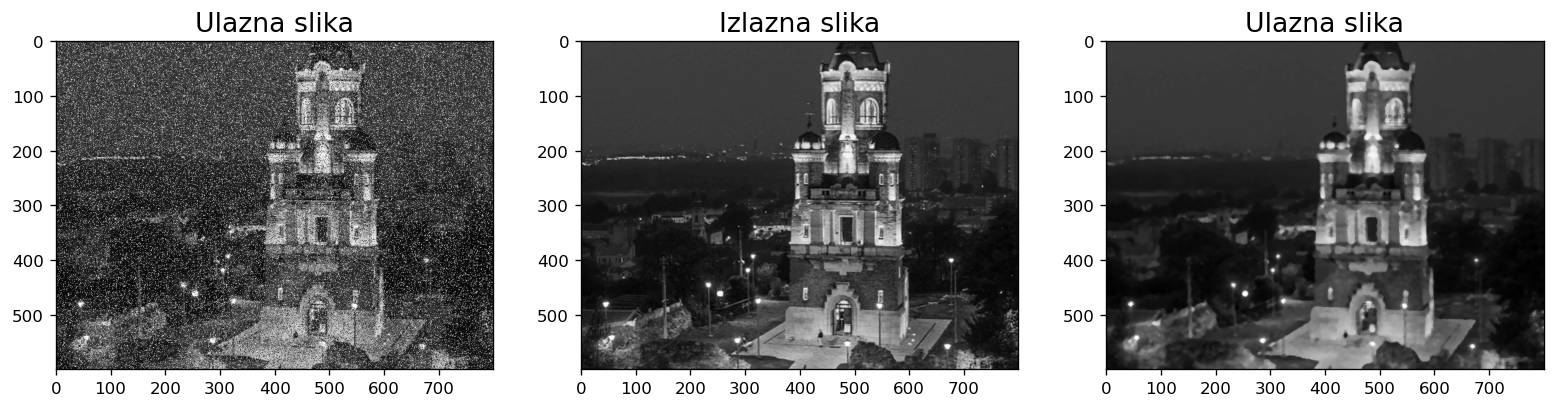

In [22]:
adaptive = True
img_in = imread('zad4/gardos.jpg')
img_in = color.rgb2gray(img_in)
img_noise = util.random_noise(img_in, mode="s&p", amount=0.2)
imsave("zad4/gardos_noise.jpg", img_noise, cmap = 'gray')
img_out_adaptive = dos_median(img_noise, 7, adaptive)
img_out_non_adaptive = dos_median(img_noise, 7, False)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,8), dpi=120)
ax = axes.ravel()

ax[0].imshow(img_noise, cmap='gray'); ax[0].set_title('Ulazna slika', fontsize=16)
ax[1].imshow(img_out_adaptive, cmap='gray'); ax[1].set_title('Izlazna slika', fontsize=16)
ax[2].imshow(img_out_non_adaptive, cmap='gray'); ax[2].set_title('Ulazna slika', fontsize=16)